## Artificial Intelligence Coursework - Code & Report 

*Andreas Vrachimis*

University of Glasgow


## Abstract

>The report investigates the implementation of AI policies and their repercussions in a COVID-19 simulated environment. Three agents have been designed, implemented and tested against one another. Random, Deterministic and Q-Learning Agent with Function Approximation and Neural Networks are among the approaches examined. Despite the different types of environments, Q Learning proved to be the more effective and robust agent. Furthermore, an extension of the Q-Learning agent has been proposed, enhancing the model's generalization, and finally, the use of established policies has been mirrored in real-world contexts.
-------


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
!pwd
os.chdir('/content/drive/MyDrive/Semester 1/AI/Coursework')
!pwd

/content
/content/drive/MyDrive/Semester 1/AI/Coursework


In [ ]:
# Obtain the notebook JSON as a string
from google.colab import _message
notebook_json = _message.blocking_request('get_ipynb', request='', timeout_sec=120)

# collate all text in Markdown cells
all_text = ''
for cell in notebook_json['ipynb']['cells']:
    if cell['cell_type'] == "markdown":
        all_text += ' '.join(cell['source'])
# replace # and \n by empty space
all_text = all_text.replace('#', '').replace('\n', '')
# find main section and reference & appendix section
before_eof, eof, after_eof = all_text.partition('===EOF===') # please do not temper with this

# count words per section, our counting method is simple and probably plays in your favor
report_word_count = len(before_eof.split())
remaining_word_count = len(after_eof.split())

print("Your report currently has {} words".format(report_word_count))
print("Your reference and appendix currently have {} words".format(remaining_word_count))

# Please respect this convention and work with it, not against it.
# We will run an independant word count check on all notebooks submitted

Your report currently has 4778 words
Your reference and appendix currently have 408 words


# 1. Introduction


## 1.1 Motivation

>Countries all across the world are dealing with an uncommon challenge as a result of the ongoing COVID-19 outbreak. To ameliorate and eventually overcome this predicament, each government must take restrictive measures on its own. Because of the uncertainties surrounding COVID-19, governments frequently take incorrect actions, irritating residents and aggravating the pandemic's situation. Using the ViRL simulated COVID-19 environment, three distinct policies will be studied utilizing a number of various methodologies such as Reinforcement Learning, aiming to mitigate the risk of the COVID-19 pandemic.

-----


## 1.2 Task Environment

>The environment utilized in the coursework is [ViRL](https://git.dcs.gla.ac.uk/SebastianStein/virl). It is a Reinforcement Learning environment that has been used to simulate the ongoing COVID-19 pandemic. We can control the virus transmission, based on the restrictive measures taken or otherwise actions. Each weekly action taken has a varied impact on the overall number of simultaneously infected and hospitalized persons, the infection rate and the economic opportunity cost, all of which are then combined into a single negative value termed reward. An optimal action on a current state is translated into a maximum weekly reward. The main objective of the environment is to replicate a 52 weeks pandemic with the highest possible total reward. As a result, the actions implemented each week must have the least impact based on the current situation/state.

>In the environment there are four restrictive measures that governments can apply to control the virus spread:
- Action 0: None
- Action 1: Full Lockdown
- Action 2: Track & Trace
- Action 3: Social Distancing

>As previously stated, the weekly chosen action reflects on both the weekly reward and the state of the pandemic. The state is divided into four population groups, as indicated below:
- State 0: Number of susceptible people
- State 1: Number of infected people
- State 2: Number of quarantined people
- State 3: Number of recovered people

>As we can see later on in the evaluation part of the report, minimizing the number of infected people as well as retaining the number of susceptible people stable can have a positive correlation with the total reward observed in a single epidemic simulation. 

>On my choice of problem_id=0, the initial state during week 1 consisting of 10 million people is shown below:
- Susceptible People: 99_980_000 cases
- Infection People: 10_000 cases 
- Quarantined People: 0 cases
- Recovered People: 10_000 cases
-----


## 1.3 PEAS Analysis

> **Performance Measure**: a unit of measurement that we have to use to determine success <br>
**Environment**: the surroundings of our agent at each instant e.g. each week <br>
**Actuators**: The tools to perform an action <br>
**Sensors**: The tools used to capture the state of the environment


# 2. Method and Implementation

>This section consists of four helper visualization functions used for evaluation purposes as well as the implementation and the description of the three agents starting from the Random Agent, Deterministic Agent and finally the Double Q Learning Agent. In addition, another type of agent is implemented in subsection 2.1 called Single Action Agent, which is created for comparison purposes.

---------



In [ ]:
!git clone https://git.dcs.gla.ac.uk/SebastianStein/virl.git

Cloning into 'virl'...
remote: Enumerating objects: 55, done.
remote: Total 55 (delta 0), reused 0 (delta 0), pack-reused 55
Unpacking objects: 100% (55/55), done.


In [ ]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.4

     |████████████████████████████████| 109.3 MB 1.3 MB/s 
     |████████████████████████████████| 3.1 MB 29.2 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
     |████████████████████████████████| 488 kB 33.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
      Successfully uninstalled tensorflow-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.6 requires tensorflow>=2.0.0, but yo

In [ ]:
import sys
sys.path.append('virl') ## to import virl, we add the virl folder cloned above to the path where Python can look for libraries (sys.path)
import virl

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import time

import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras.optimizers import Adam

from collections import namedtuple
from collections import deque
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

## 2.0 Helper functions for evaluation metrics

More details in [Section 3.1](#section_3.1)

<a name="visualization_1"></a>

**Visualization 1: *Training Rewards Vs Episodes***


In [ ]:
def plot_training_vs_episodes(stats, params_label, smoothing_window=5):
  
  fig, axes = plt.subplots(figsize = (19,8))

  for i, stat in enumerate(stats):

    rewards_smoothed = pd.Series(stat).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed, label=params_label[i])

  plt.xlabel("Episode")
  plt.ylabel("Episode Reward (Smoothed)")
  plt.grid(True)
  plt.legend()
  plt.title("Training Convergence")
  plt.show()

<a name="visualization_2"></a>
**Visualization 2: *Episode Stats***




In [ ]:
def episode_stats(actions, states, rewards):
  weeks = range(len(actions))

  fig, axes = plt.subplots(1, 2, figsize=(15, 8))
  labels = ['s[0]: susceptibles', 's[1]: infectious', 's[2]: quarantined', 's[3]: recovereds']
  states = np.array(states)

  action_color_label = {
      0: ('yellow','No Action'),
      1: ('green','Full Lockdown'),
      2: ('black', 'Track and Trace'),
      3: ('red', 'Social Distancing')
  }

  for i in range(4):
      axes[0].plot(states[:,i], label=labels[i], linewidth=5);

  axes[0].set_xlabel('weeks since start of epidemic')
  axes[0].set_ylabel('State s(t)')

  for week, action in zip(weeks, actions):
    axes[0].axvspan(week, week+1, facecolor=action_color_label[action][0], alpha=0.3, label=action_color_label[action][1])
    axes[1].axvspan(week, week+1, facecolor=action_color_label[action][0], alpha=0.3, label=action_color_label[action][1])


  # remove duplicate labels
  handles, labels = axes[0].get_legend_handles_labels()
  by_label = dict(zip(labels, handles))
  axes[0].legend(by_label.values(), by_label.keys())
  

  axes[1].plot(rewards);
  axes[1].set_title('Reward')
  axes[1].set_xlabel('weeks since start of epidemic')
  axes[1].set_ylabel('reward r(t)')
  axes[1].annotate('Total Reward\n{:.4f}'.format(np.sum(rewards)),xy=(0.7,0.05), xycoords='axes fraction', fontsize = 20)

<a name="visualization_3"></a>
**Visualization 3: *Episode Stats All Agents***


In [ ]:
def episode_stats_all_agents(agents_actions, agents_states, agents_rewards, environment_type):
  
  fig, axes = plt.subplots(3, 2, figsize=(20, 14))
  action_color_label = {
        0: ('yellow','No Action'),
        1: ('green','Full Lockdown'),
        2: ('black', 'Track and Trace'),
        3: ('red', 'Social Distancing')
    }

  index_agent = {
        0: "Random Agent",
        1: "Deterministic Agent",
        2: "Q Learning Agent",
    }

  labels = ['s[0]: susceptibles', 's[1]: infectious', 's[2]: quarantined', 's[3]: recovereds']

  for i in range(len(agents_actions)):
    # get the actions, states and rewards from one of the three agents
    actions = agents_actions[i]
    states = agents_states[i]
    states = np.array(states)
    rewards = agents_rewards[i]
  

    for j in range(4):
        axes[i,0].plot(states[:,j], label=labels[j], linewidth=5);

    axes[i,0].set_xlabel('weeks since start of epidemic')
    axes[i,0].set_ylabel('State s(t)')
    axes[i,0].set_title('{}: States Evolution for 52 weeks'.format(index_agent[i]))

    # axes[0].pcolorfast(axes.get_xlim(), axes.get_ylim(),
    #             df['B'].values[np.newaxis],
    #             cmap='RdYlGn', alpha=0.3)

    for week, action in zip(range(52), actions):
      axes[i,0].axvspan(week, week+1, facecolor=action_color_label[action][0], alpha=0.3, label=action_color_label[action][1])
      axes[i,1].axvspan(week, week+1, facecolor=action_color_label[action][0], alpha=0.3, label=action_color_label[action][1])

    # remove duplicate labels
    handles, labels = axes[i,0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[i,0].legend(by_label.values(), by_label.keys())
    

    axes[i,1].plot(rewards);
    axes[i,1].set_title('{} Reward'.format(index_agent[i]))
    axes[i,1].set_xlabel('weeks since start of epidemic')
    axes[i,1].set_ylabel('reward r(t)')
    axes[i,1].annotate('Total Reward\n{:.4f}'.format(np.sum(rewards)),xy=(0.7,0.05), xycoords='axes fraction', fontsize = 20)

  fig.tight_layout()
  fig.suptitle('Evolution of the states, actions and reward for each of the three agents for one epidemic simulation\nEnvironment={}'.format(environment_type), fontsize='xx-large')
  fig.subplots_adjust(top=0.9)

<a name="visualization_4"></a>
**Visualization 4: *Agent Total Reward Vs Episodes All Agents***


In [ ]:
def agent_total_reward_vs_episode_all_agents(stats, env_type, smoothing_window=5):
  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (19,8))

  data = []
  # iterate through the IDs
  for index, stat in enumerate(stats):
    mean = np.mean(stat)
    std = np.std(stat)

    data.append([mean, std])

    rewards_smoothed = pd.Series(stat).rolling(smoothing_window, min_periods=smoothing_window).mean()
    ax1.plot(rewards_smoothed)

  ax1.set_xlabel("Episode")
  ax1.set_ylabel("Episode Total Reward ")
  ax1.grid(True)
  ax1.legend(['Random','Deterministic', 'Q-Learning'])

  data = np.array(data)
  data_df = pd.DataFrame(data, columns=['Mean','Std'], index=['Random','Deterministic', 'Q-Learning'])
  data_df = data_df.round(3)
  
  table = ax2.table(cellText=data_df.values, colLabels=data_df.columns, rowLabels=data_df.index, loc='center', colWidths=[0.3]*3, cellLoc='center')
  table.set_fontsize(15)
  table.scale(2,2)
  ax2.axis('off')

  fig.tight_layout()
  fig.suptitle('Total reward, mean and std over 50 episodes for all the three agents\nEnvironment: {}'.format(env_type), fontsize='xx-large')
  fig.subplots_adjust(top=0.9)

## 2.1 Random Agent

>The following code cell consists of the function random_agent. The function takes a single argument, the ViRL environment and returns a three-element tuple with the actions, rewards and states for the simulation of the agent for one year / 52 weeks. The three-element tuple will keep track of the action, reward and state on weekly basis. As mentioned above the simulation enters a while loop which is executed and terminated after 52 iterations/weeks. During each iteration/week a random action is implemented from the list of the available actions, None, Full Lockdown, Track & Trace and Social distancing. The state and the reward are then recorded and the process keeps iterating until the termination condition is met. 

In [ ]:
def random_agent(environment):
  """
  function used to simulate the evolution of pandemic based on a random agent for 52 weeks
  """

  # the three lists are to keep track of our data
  actions, rewards, states = [],[],[]

  done = False

  state = environment.reset()
  
  states.append(state)


  # iterate until 52 weeks are reached

  while not done:
    # choose a random action from the action space
    action = np.random.choice(environment.action_space.n)
    actions.append(action)

    # take a step based on the random action and save new state and rewards
    state, reward, done, i = environment.step(action)

    states.append(state)
    rewards.append(reward)

  return actions, rewards, states

**Single Action Agent**

>The following function simulates a single action agent, an agent that takes only one action throughout the simulation. It follows exactly the same procedure as the Random Agent with the main difference that the action specified at the beginning is constantly taking place throughout the entire episode. The reason why I have implemented the current agent is to compare its performance with my deterministic policy agent.

In [ ]:
def single_action_agent(environment, action=0):
  
  # the three lists are to keep track of our data
  actions, rewards, states = [],[],[]

  done = False

  state = environment.reset()

  states.append(state)

  # iterate until 52 weeks are reached

  while not done:
    # implement a single action throughout the 52 weeks simulation
    actions.append(action)

    # take a step based on the random action and save new state and rewards
    state, reward, done, i = environment.step(action)

    states.append(state)
    rewards.append(reward)

  return actions, rewards, states

In [ ]:
env = virl.Epidemic(problem_id = 0)

actions = ['None             ','Full Lockdown   ','Track & Trace     ','Social Distancing']
print("Action    \t    | Total Reward")
for i, action in enumerate(actions):
  dummy_actions, dummy_rewards, dummy_states = single_action_agent(env, i)
  print("{}\t{:.2f}".format(actions[i],np.sum(dummy_rewards)))
  # episode_stats(dummy_actions, dummy_states, dummy_rewards)

Action    	    | Total Reward
None             	-1.92
Full Lockdown   	-1.63
Track & Trace     	-2.01
Social Distancing	-2.06


## 2.2 Deterministic Agent

>The following two code cells consist of my deterministic agent policy. The first code cell includes the deterministic policy while the second code cell simulates the process over 52 weeks.
* deterministic_agent_policy function takes two arguments, the record of all the states and actions until the current week and returns the next action to be performed based on our policy. 
* deterministic_simulator function takes a single argument, the ViRL environment and returns the weekly actions, rewards and states of the agent for the entire time of the simulation.

>**Policy** <br>
>The policy on each week is mainly based on the rate of change of the number of infected people from the current week compared to the previous week. During the first week of the simulator our chosen action is always `None` but from the second week and onwards rate of change of the number of infected people is taken into account and if it is above a certain threshold value, the next action to be taken is always a `Full Lockdown` (Action 1). In the upcoming weeks, if the rate of change is less than the threshold values, regulations are becoming more relaxed moving into the next less impactful action. Once the `None` action is performed, it remains for the next weeks until the rate of change of infected people exceeds the threshold value once again. The impact order of the actions is shown below starting from the most impactful until the least impactful.
- `Full Lockdown` - Action 1
- `Track & Trace` - Action 2
- `Social Distancing` - Action 3
- `None` - Action 0

>For my deterministic policy, the threshold value chosen is `1.32`. This means that the deterministic agent implements a `Full Lockdown` if the number of infected people has increased by 1/3 compared to the previous week. The value can be adapted based on the sensitivity that we want to have in our policy. A higher value means that our agent requires a greater rate of change to trigger for a Full Lockdown while a lower value can make our model very sensitive and each time a small increase is observed a Full Lockdown will take place. 

>Such policy will not allow sudden jumps between unrelated actions. 'Regulations' are relaxed in a weekly manner which makes the policy close enough to real-world scenarios. 


In [ ]:
def deterministic_agent_policy(previous_states, previous_actions):
    
    current_infected_people = previous_states[-1][1]
    threshold = 1.32
    # in week 1 start with no action
    if len(previous_states) == 1:
      action=0 

    else:

      prev_infected_people = previous_states[-2][1]

      # calculate rate of change of infected people from previous week to current week
      rate_of_change_infectious = (current_infected_people - prev_infected_people)/prev_infected_people

      # if rate of change bigger than threshold, go for a full lockdown
      if rate_of_change_infectious > threshold:
        action = 1

      else:
        # otherwise, go to the next less impactfull action
        prev_action = previous_actions[-1]

        if prev_action == 0: 
          action = 0
        else:
          # continue with the next least impactful action
          action = (prev_action + 1) % 4

    return action

In [ ]:
def deterministic_simulator(env):

  actions, rewards, states = [],[],[]
  done = False

  state = env.reset()

  states.append(state)

  # iterate for 52 weeks
  while not done:

    # decide the action to be taken based on the policy implemented
    action = deterministic_agent_policy(states, actions)
    actions.append(action)

    # make a step and receive state, reward and termination status
    state, reward, done, i = env.step(action)

    states.append(state)
    rewards.append(reward)

  return actions, rewards, states

## 2.3 Double Q-Learning with Function Approximation using NN

The current agent's implementation is made up of three primary classes: the NN Function Approximator, the Q-Learning Agent, and the Replay Memory classes.

1. **NN Function Approximator**
> The Huber loss function, the NN construction, and the optimizer are all included in this class.
>
>**Hubber Loss Function**: This function combines MAE and MSE, making it an excellent choice for dealing with outliers.
>
>**NN architecture**: The NN implemented consists of three main elements, the input layer, the hidden layers and the activation layer. The input layer accepts four features, which are the same as the number of states. The hidden layer configuration will be determined later in the report via parameter tuning. [24x24],[32x32] and [64x64] are examples of sensible values. Finally, the activation layer outputs a set of four features, one for each state.
>
>**Adam optimizer**: it is a computationally efficient evolution of the SGD optimizer that adjusts network weights iteratively based on training data.

2. **Q-Learning Agent**
> In order to update the weights of the NN implemented, an update strategy must be utilized by the agent. Agents must come up with specific policies for each available action based on NN Function Approximators. These policies are determined by the Q values and they form a model. Therefore in this case there are four distinct models where a Q(s,a) value is returned given the state and the action. 
>
>In addition, the current agent utilizes two NNs with the same architecture but different weights. For every episode, weights are loaded from the main to the target NN. Consequently, the stability and efficiency of the learning process are improved [2].
>
>When an action is taken, the weights of the NN are updated according to the Bellman equation. $$\hat Q_w(s,a) = R(s) + \gamma {\max _{a'}}\hat Q_w(s',a')$$
To predict the next action, the state is given to the function approximator which returns 4 q values. The action with the highest q value is picked as the next action.
>
>In general, the procedure goes as follow:
  *   Run episode N times
    *  Based on the current weights of the NN, create a policy
    *  Starting from the first week, an epidemic simulation of 52 weeks is executed
    *  From the policy created earlier, perform an action and record the state and the reward
    *  Calculate loss and update NN weights using the Adam optimizer
    *  Copy weights from main to the target NN
    *  Repeat until the episode is terminated

3. **Replay Memory**
>It is used to store the states of the agent during the training phase. The memory is randomly sampled and updates our model. This resolves the problem of overfitting since it ensures that the states are not correlated with each other [1]. 


----------


**Neural Network with Function Approximation Implementation**

In [ ]:
# code used from Lab 8 Part II
class NNFunctionApproximatorJointKeras():
    """ 
    A basic MLP neural network approximator and estimator using Keras     
    """
    
    def __init__(self, alpha, d_states, n_actions, nn_config, verbose=False):        
        self.alpha = alpha    
        self.nn_config = nn_config      # determines the size of the hidden layer (if any)             
        self.n_actions = n_actions        
        self.d_states = d_states
        self.verbose = verbose # Print debug information        
        self.n_layers = len(nn_config)                
        self.model = self._build_model()                
                        
    def _huber_loss(self,y_true, y_pred, clip_delta=1.0):
        """
        Huber loss (for use in Keras), see https://en.wikipedia.org/wiki/Huber_loss
        The huber loss tends to provide more robust learning in RL settings where there are 
        often "outliers" before the functions has converged.
        """
        error = y_true - y_pred
        cond  = K.abs(error) <= clip_delta
        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)
        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning 
        model = Sequential()
        for ilayer in self.nn_config:
            model.add(Dense(ilayer, input_dim=self.d_states, activation='relu'))        
        model.add(Dense(self.n_actions, activation='linear'))
        model.compile(loss=self._huber_loss, # define a special loss function
                      optimizer=Adam(lr=self.alpha, clipnorm=10.)) # specify the optimiser, we clip the gradient of the norm which can make traning more robust
        return model

    def predict(self, s, a=None):              
        if a==None:            
            return self._predict_nn(s)
        else:                        
            return self._predict_nn(s)[a]
        
    def _predict_nn(self,state_hat):                          
        """
        Predict the output of the neural netwwork (note: these can be vectors)
        """                
        x = self.model.predict(state_hat)                                                    
        return x
  
    def update(self, states, td_target):           
        self.model.fit(states, td_target, epochs=1, verbose=0) # take one gradient step usign Adam               
        return 

**Q Learning Agent Implementation**

In [ ]:
# the code used is refactored from Lab 8 part II 
class QLearningAgent():

  def __init__(self, env, func_approximator, func_approximator_target, num_episodes = 100, discount_factor=0.95, epsilon_init=0.01, epsilon_decay=0.99995, buffer_size = 10000, batch_size = 128,
               epsilon_min=0.01, use_batch_updates=True, fn_model_in=None, fn_model_out=None):
    
    self.env = env
    self.func_approximator = func_approximator
    self.func_approximator_target = func_approximator_target
    self.num_episodes = num_episodes
    self.discount_factor = discount_factor
    self.epsilon_init = epsilon_init 
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = epsilon_min 
    self.use_batch_updates = use_batch_updates
    self.fn_model_in = fn_model_in
    self.fn_model_out = fn_model_out

    self.buffer_size = buffer_size
    self.memory = ReplayMemory(self.buffer_size)  
    self.n_actions = self.env.action_space.n        
    self.d_states  = self.env.observation_space.shape[0]    
    self.best_reward = -10
    self.batch_size = batch_size

    self.reward_total = []


  def load_model_trained_weights(self):
    """method used to load the weights of pre-trained models"""
    self.func_approximator.model.load_weights(self.fn_model_in)
    self.func_approximator_target.model.set_weights(self.func_approximator.model.get_weights())


  def training(self):
    """method used to train the model for N number of episodes"""

    if not self.fn_model_in is None:
      self.func_approximator.model.load_weights(self.fn_model_in)
      self.func_approximator_target.model.set_weights(self.func_approximator.model.get_weights())

    for episode in range(self.num_episodes):

      rewards_ep = []
      states_ep  = []

      # start from the first state/week
      state = self.env.reset()
      states_ep.append(state)

      # reshape and normalize state
      state = np.reshape(state/np.sum(state),[1,self.d_states])
      done = False

      # iterate over the entire 52 weeks simulation
      while not done:

        if np.random.rand() <= self.epsilon_init:
          action = random.randrange(self.n_actions)
        else:
          # predict the next action by getting the action with the highest q value
          act_value = self.func_approximator.predict(state)[0]
          action = np.argmax(act_value)

        # perform the action picked and record the next_state, reward and done
        next_state, reward, done, _ = self.env.step(action)

        rewards_ep.append(reward)
        states_ep.append(next_state)

        # reshape and normalize
        next_state = np.reshape(next_state/np.sum(next_state), [1,self.d_states])

        # push the transition into the memory
        if done:
          self.memory.push(state, action, next_state, reward, 0.0)
        else:
          self.memory.push(state, action, next_state, reward, 1.0)

        
        # if transitions are enough
        if len(self.memory) >= self.batch_size:

          # sample from the buffer
          transitions = self.memory.sample(self.batch_size)

          batch = Transition(*zip(*transitions))                                
          train_rewards = np.array(batch.reward)
          train_states = np.array(batch.state)
          train_next_state = np.array(batch.next_state)
          train_actions = np.array(batch.action)
          train_is_not_terminal_state = np.array(batch.is_not_terminal_state)  
                  
          if self.use_batch_updates:
            # Do a single gradient step computed based on the full batch
            train_td_targets    = self.func_approximator.predict(train_states.reshape(self.batch_size,4)) # predict current values for the given states
            q_values_next       = self.func_approximator_target.predict(np.array(batch.next_state).reshape(self.batch_size,self.d_states))                    
            train_td_targetstmp = train_rewards + self.discount_factor * train_is_not_terminal_state * np.amax(q_values_next,axis=1)                
            train_td_targets[ (np.arange(self.batch_size), train_actions.reshape(self.batch_size,).astype(int))] = train_td_targetstmp                                                                              

            self.func_approximator.update(train_states.reshape(self.batch_size,self.d_states), train_td_targets) # Update the function approximator using our target       

          else:
            # Do update in a truely online sense where a gradient step is performed per observation
            for s in range(train_rewards.shape[0]):
              target = self.func_approximator.predict(train_states[s])[0]
              q_next = self.func_approximator_target.predict(train_next_state[s])[0]
              target[train_actions[s]] = train_rewards[s] + self.discount_factor * train_is_not_terminal_state[s] * np.amax(q_next)                        
              self.func_approximator.update(train_states[s], target.reshape(1,self.n_actions)) # Update the function approximator using our target                                            

          # update epsilon value into it reaches its minimum value
          if self.epsilon_init > self.epsilon_min:
            self.epsilon_init *= self.epsilon_decay 

        state = next_state 


        if done:

          curr_ep_rewards = np.sum(rewards_ep)
        
          self.reward_total.append(curr_ep_rewards)
          
          # copy weights from the main to the target NN
          self.func_approximator_target.model.set_weights(self.func_approximator.model.get_weights())   

          print("\rEpisode: {}/{}, Total Reward: {}, epsilon: {:.2}".format(episode, self.num_episodes, curr_ep_rewards, self.epsilon_init), end="")                               

          # save weights with the minimumm total reward
          if self.fn_model_out is not None and ( curr_ep_rewards >= self.best_reward):
            self.func_approximator.model.save_weights(self.fn_model_out)

            self.best_reward = curr_ep_rewards
          
          break


  def run_agent_51_weeks(self, env):

    self.env = env

    rewards, actions, states = [], [], []
    done = False

    # start from week 1
    state = self.env.reset()
    states.append(state)

    # reshape and normalize the state
    state = np.reshape(state/np.sum(state),[1,self.d_states])


    while not done:
      # predict next action with the highest q value based on function approximator
      act_value = self.func_approximator.predict(state)[0]
      action = np.argmax(act_value)      

      actions.append(action)

      # implement next action and record next_state and reward
      next_state, reward, done, _ = self.env.step(action)

      rewards.append(reward)
      states.append(next_state)

      # reshape and normalize state again
      state = np.reshape(next_state/np.sum(next_state),[1,self.d_states])

    return rewards, actions, states



**Replay Memory**

In [ ]:
# code used from Lab 8 part II
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','is_not_terminal_state'))

class ReplayMemory():
    """
    Implement a replay buffer using the deque collection
    """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)               

    def push(self, *args):
        """Saves a transition."""
        self.memory.append(Transition(*args))

    def pop(self):
        return self.memoery.pop()

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)   

    def __len__(self):
        return len(self.memory)

# 3. Results

>In this section the performance of all the three implemented agents is evaluated and tested in different environment types. The environment types include Deterministic, Deterministic with noise and finally Stochastic with noise. In addition, section 3.1 reflects on how the performance comparison has been conducted explaining the visualizations/evaluation metrics used in the report. Moreover, section 3.2 includes the training of the model as well as tuning critical hyperparameters.<br><br> 
Throughout the training, evaluation and testing, the problem ID that I picked is `problem_id = 0`. Additionally, random seed has been used to ensure results in noisy and random environments are reproducible.

-------

In [ ]:
def set_seed(seed, verbose=True):
    if verbose:
        print('Setting seed to {}'.format(seed))
    random.seed(seed)
    np.random.seed(seed)
set_seed(0)

Setting seed to 0


<a name="section_3.1"></a>
## 3.1 Evaluation metrics

Four different types of evaluation metrices are used in the report to investigate the performance and the behavior of the three implemented agents in different environment types. Evaluation metrices are presented in the table below, along with a hyperlink pointing to their function implementation and a hyperlink pointing to an example of them.

||Visualization|Function Implementation|Example|  
|---|---|---|---|
|1.|Training Rewards Vs Episodes|[Function 1](#visualization_1)|[Example 1](#example_1)|
|2.|Episode Stats|[Function 2](#visualization_2)|[Example 2](#mandatory_1)|
|3.|Episode Stats All Agents|[Function 3](#visualization_3) | [Example 3](#mandatory_1)|
|4.|Agent Total Reward Vs Episodes All Agents|[Function 4](#visualization_4)|[Example 4](#example_4)|

#### Visualization 1: Training Rewards Vs Episodes
> This visualization is used to evaluate the training of the Q Learning agent. The total reward of each episode is displayed along with the corresponding episode. From the current visualization, we can see the learning of the Q-Learning Agent and whether it has converged into a stable total reward value. In addition, I have personally used it for hyperparameters tuning by choosing the parameters of agents that converged into a minimum reward as well as having a more stable conversion.  

#### Visualization 2: Episode Stats
> The second visualization is a 2x1 plot displaying the stats of the given agent over a single simulation/52 weeks. The left subplot shows the evolution of the four states over a single episode displaying in the background the transition of the four different actions, while the right subplot displays the evolution of the reward over a single episode and the total reward of it. From this visualization, we can observe the way each action affects the reward as well as the states of the agent. e.g. decrease in the number of infected people when a Full Lockdown is taking place.

#### Visualization 3: Episode Stats All Agents
> This is the visualization described as *Mandatory*. It is a 2x3 plot and displays the evolution of all the three stats of the agent (actions, states, rewards) for a single episode.  The current visualization operates in exactly the same manner as visualization 2, with the only difference that stats of all the three agents are plotted in a single visualization. It is used three times in the report using three different environment types. 

#### Visualization 4: Agent Total Reward Vs Episodes All Agents
> The last visualization is used to measure the mean and the standard deviation of the performance of all the three agents and therefore evaluate their robustness. It is a 2x1 visualization, where the left plot displays the total reward of all the three agents for a number of episodes and the right plot/matrix presents the mean (μ) and the standard deviation (σ) for each of the tree agents. This visualization has been used three times in the report, one for each environment type.

-------


#### ***Mandatory Visualisations***

> The mandatory visualization presents the evolution of states, actions and rewards for the three implemented agents over a single simulation. A hyperlink is given for each of the three environment types.

- [3.2 Mandatory Visualization - Deterministic Environment](#mandatory_1)
- [3.3 Mandatory Visualization - Deterministic Noisy Environment](#mandatory_2)
- [3.4 Mandatory Visualization - Stochastic Noisy Environment](#mandatory_3)

---------


## 3.2 Determinitic ViRL problem

> The current section consists of parameter tuning, model training and evaluation of the deterministic environment on all the three agents created.
-----

#### Hyperparameter Tuning

> In order to optimize the performance and robustness of my Q Learning agent, manual parameter tuning has been utilized. I focused on optimizing the `nn_config` and `alpha` parameters of the NN, however, due to the training time required for each agent, I kept the range of my parameters as low as possible. The parameter values are shown below:
- alpha:  0.001, 0.005 
- nn_config: 24x24, 32x32, 64x64

> Six different agents are then trained. The code used to train the agents based on different parameters is presented on the next code cells. In addition, agents_performance__df.csv stores the total reward of each episode on all six agents for 500 episodes. agents_performance_df.csv file will be submitted along with the notebook file. Each column represents a different trained agent with the parameters specified on the column name, and each row represents the total reward of a single episode.  




In [ ]:
env = virl.Epidemic(problem_id=0)

d_states    = env.observation_space.shape[0]
n_actions   = env.action_space.n

alphas = [0.001, 0.005]          
nn_configs = [[24,24],[32,32],[64,64]]

In [ ]:
total_rewards_df = pd.DataFrame()

print("Problem ID: 0")

for alpha in alphas:
  for nn_config in nn_configs:
    start_time = time.time()
            
    nn_func_approximator = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)
    nn_func_approximator_target = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)
  
    al = str(alpha).split(".")[1]

    qlearning_agent = QLearningAgent(env,nn_func_approximator, nn_func_approximator_target, num_episodes=500, epsilon_init=0.1, epsilon_decay=0.995, epsilon_min=0.001, fn_model_in=None, fn_model_out = "trained_agents/trained_agent_id_0_{}_{}.h5".format(nn_config[0],al))

    print("Model Parameters: alpha={} \t nn_configs={}".format(alpha, nn_config))
    
    qlearning_agent.training()
    
    qlearning_total_rewards_episodes = qlearning_agent.reward_total
    t_rewards = np.array(qlearning_total_rewards_episodes)

    total_rewards_df["NN_{}_{}".format(nn_config[0], alpha)] = t_rewards


    print('\nModel Training Time: {:.2f}s\n'.format(time.time()-start_time))

Problem ID: 0




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model Parameters: alpha=0.001 	 nn_configs=[24, 24]


Episode: 499/500, Total Reward: -1.2695469109105997, epsilon: 0.001
Model Training Time: 302.21s

Model Parameters: alpha=0.001 	 nn_configs=[32, 32]
Episode: 499/500, Total Reward: -1.1958268071300096, epsilon: 0.001
Model Training Time: 313.54s

Model Parameters: alpha=0.001 	 nn_configs=[64, 64]
Episode: 499/500, Total Reward: -1.3548502543492884, epsilon: 0.001
Model Training Time: 339.76s

Model Parameters: alpha=0.005 	 nn_configs=[24, 24]
Episode: 499/500, Total Reward: -1.16677935346597, epsilon: 0.001
Model Training Time: 424.36s

Model Parameters: alpha=0.005 	 nn_configs=[32, 32]
Episode: 499/500, Total Reward: -1.2030679247393348, epsilon: 0.001
Model Training Time: 365.40s

Model Parameters: alpha=0.005 	 nn_configs=[64, 64]
Episode: 499/500, Total Reward: -1.1880709841865995, epsilon: 0.001
Model Training Tim

In [ ]:
# save csv file created
total_rewards_df.to_csv('agents_performance_df.csv', index=False)

Uncomment to load parameter tuning models stats

In [ ]:
# # load csv file
# total_rewards_df = pd.read_csv('agents_performance_df.csv')  
# total_rewards_df

,NN_24_0.001,NN_32_0.001,NN_64_0.001,NN_24_0.005,NN_32_0.005,NN_64_0.005
0,-2.056117,-2.914126,-2.270102,-1.900009,-1.998724,-1.563744
1,-2.067842,-2.894945,-2.237355,-2.018575,-2.117134,-1.590684
2,-2.048496,-2.161780,-2.257564,-2.071404,-2.100562,-1.505046
3,-1.918100,-1.959967,-1.802039,-2.308368,-1.661040,-2.049195
4,-1.980299,-1.233128,-1.822229,-2.143540,-2.103536,-1.869672
...,...,...,...,...,...,...
495,-1.253020,-1.229811,-1.199402,-1.238410,-1.260484,-1.193308
496,-1.243591,-1.205455,-1.210143,-1.179748,-1.261084,-1.178116
497,-1.269389,-1.196636,-1.219682,-1.268813,-1.198560,-1.174969
498,-1.258306,-1.195910,-1.213349,-1.241199,-1.195554,-1.173111


**Trained Agents Evaluation**

> To evaluate the performance and robustness of all the individual trained agents, mean (μ), standard deviation (σ) and maximum reward have been calculated and considered. Since during the first episodes of the training process, the agents 'learns', I decided to exclude the first 50 episodes from the calculation of the aforementioned metrics. As shown on the output of the next code cell, the agents with alpha = 0.001, performed better considering the standard deviation value, which means that once they have converged, the total reward value varied and oscillated less compared to agents where alpha = 0.005 was used. Therefore, I decided to use 0.001 for my alpha parameter. 

> In regards to the nn_config parameter with agents having as alpha = 0.001, agent 3 with nn_config = 64x64 outperforms all the other agents in mean and standard deviation. Even though the chosen agent does not have the best maximum reward value, the difference is negligible to be considered important. Therefore I decided to choose agent 3 as the agent with the best parameters.

 || Hyperparameters  | Optimal Value  |   
|---|---|---|
|1.| alpha | 0.001 |
|2.| nn_config | 64x64 | 

In [ ]:
agent_1 = total_rewards_df.iloc[:,0]
agent_2 = total_rewards_df.iloc[:,1]
agent_3 = total_rewards_df.iloc[:,2]
agent_4 = total_rewards_df.iloc[:,3]
agent_5 = total_rewards_df.iloc[:,4]
agent_6 = total_rewards_df.iloc[:,5]

agent_1_50 = agent_1[50:]
agent_2_50 = agent_2[50:]
agent_3_50 = agent_3[50:]
agent_4_50 = agent_4[50:]
agent_5_50 = agent_5[50:]
agent_6_50 = agent_6[50:]

print("      nn_config alpha\t Mean\tstd\tMaxReward\n    \t\t       --------------------------")
print("Agent 1: 24x24\t0.001\t{:.3f}\t{:.3f}\t{:.3f}".format(np.mean(agent_1_50), np.std(agent_1_50), np.max(agent_1)))
print("Agent 2: 32x32\t0.001\t{:.3f}\t{:.3f}\t{:.3f}".format(np.mean(agent_2_50), np.std(agent_2_50), np.max(agent_2)))
print("Agent 3: 64x64\t0.001\t{:.3f}\t{:.3f}\t{:.3f}".format(np.mean(agent_3_50), np.std(agent_3_50), np.max(agent_3)))
print("Agent 4: 24x24\t0.005\t{:.3f}\t{:.3f}\t{:.3f}".format(np.mean(agent_4_50), np.std(agent_4_50), np.max(agent_4)))
print("Agent 5: 32x32\t0.005\t{:.3f}\t{:.3f}\t{:.3f}".format(np.mean(agent_5_50), np.std(agent_5_50), np.max(agent_5)))
print("Agent 6: 64x64\t0.005\t{:.3f}\t{:.3f}\t{:.3f}".format(np.mean(agent_6_50), np.std(agent_6_50), np.max(agent_6)))


      nn_config alpha	 Mean	std	MaxReward
    		       --------------------------
Agent 1: 24x24	0.001	-1.336	0.149	-1.229
Agent 2: 32x32	0.001	-1.243	0.110	-1.128
Agent 3: 64x64	0.001	-1.240	0.083	-1.158
Agent 4: 24x24	0.005	-1.290	0.184	-1.155
Agent 5: 32x32	0.005	-1.251	0.092	-1.148
Agent 6: 64x64	0.005	-1.245	0.132	-1.130


<a name="example_1"></a>

> A figure with the total reward per episode in relation to the training episodes is presented below. Only trained agents with alpha = 0.001 are shown, to make the visualization more clear.

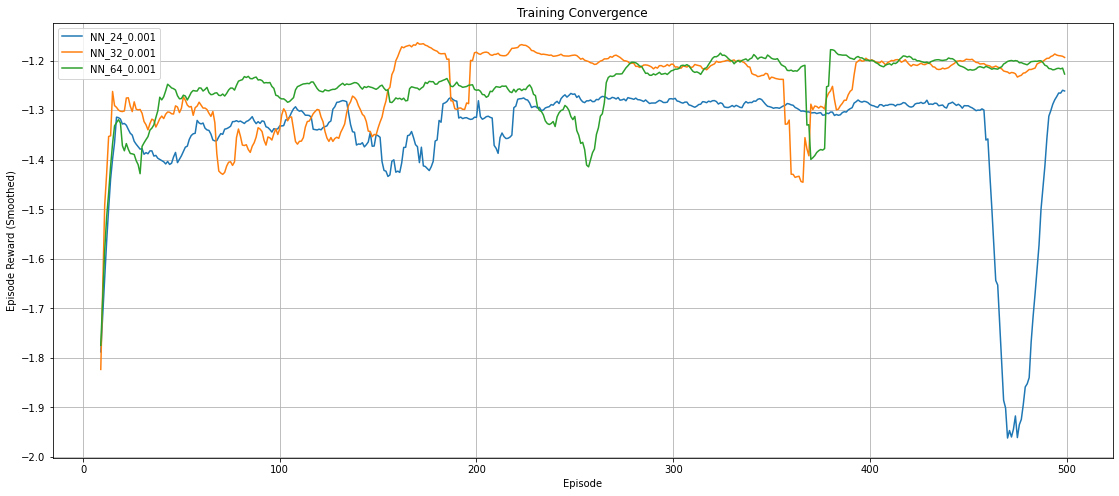

In [ ]:
plot_training_vs_episodes([agent_1, agent_2, agent_3],params_label = total_rewards_df.columns[:3] ,smoothing_window=10)

#### Agent Training - Q Learning

> Based on the optimal parameters chosen, the final Q Learning Agent will be trained and evaluated over the next section.


In [ ]:
# NN and qlearning agent parameters
env = virl.Epidemic(problem_id=0)

d_states    = env.observation_space.shape[0]
n_actions   = env.action_space.n

alpha = 0.001          
nn_config = [64,64]    

In [ ]:
with tf.device("/gpu:0"):
  start_time = time.time()
          
  nn_func_approximator = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)
  nn_func_approximator_target = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)
 
  qlearning_agent = QLearningAgent(env,nn_func_approximator, nn_func_approximator_target, num_episodes=500, epsilon_init=0.1, epsilon_decay=0.995, epsilon_min=0.001, fn_model_in=None, fn_model_out = "trained_agents/trained_agent_id_0_64_001.h5")
  print("Problem ID: 0")
  
  qlearning_agent.training()
  
  qlearning_total_rewards_episodes = qlearning_agent.reward_total
  

  print('\nModel Training Time: {:.2f}s\n'.format(time.time()-start_time))
    





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Problem ID: 0


Episode: 499/500, Total Reward: -1.2130238569149445, epsilon: 0.001
Model Training Time: 263.67s



> A graph of the episode total reward in relation to each episode is presented below. From the graph, we can observe that over the 500 episodes, the agent has reached a stable point and therefore converged relatively early in the training process at around 40 episodes. This indicates that our agent is learning and improving its performance especially in the early stages of the training phase. 

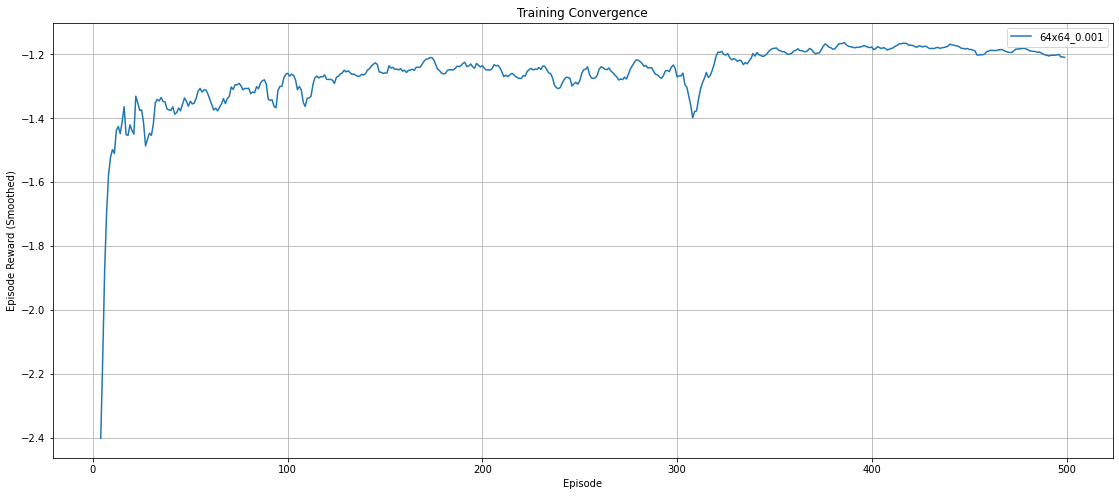

In [ ]:
plot_training_vs_episodes([np.array(qlearning_total_rewards_episodes)],params_label = ['64x64_0.001'] ,smoothing_window=5)

#### Deterministic Environment
>For each of the three agents, a single epidemic simulation of 52 weeks has been run and visualized using a deterministic environment

In [ ]:
env = virl.Epidemic(problem_id = 0)

Random Agent

In [ ]:
random_actions, random_rewards, random_states = random_agent(env)
# episode_stats(random_actions, random_states, random_rewards)

Deterministic Agent

In [ ]:
deterministic_actions, deterministic_rewards, deterministic_states = deterministic_simulator(env)
# episode_stats(deterministic_actions, deterministic_states, deterministic_rewards)

Q-Learning Agent

In [ ]:
qlearn_rewards, qlearn_actions, qlearn_states = qlearning_agent.run_agent_51_weeks(env)
# episode_stats(qlearn_actions, qlearn_states, qlearn_rewards)

<a name="mandatory_1"></a>

#### Mandatory Visualization 3.2

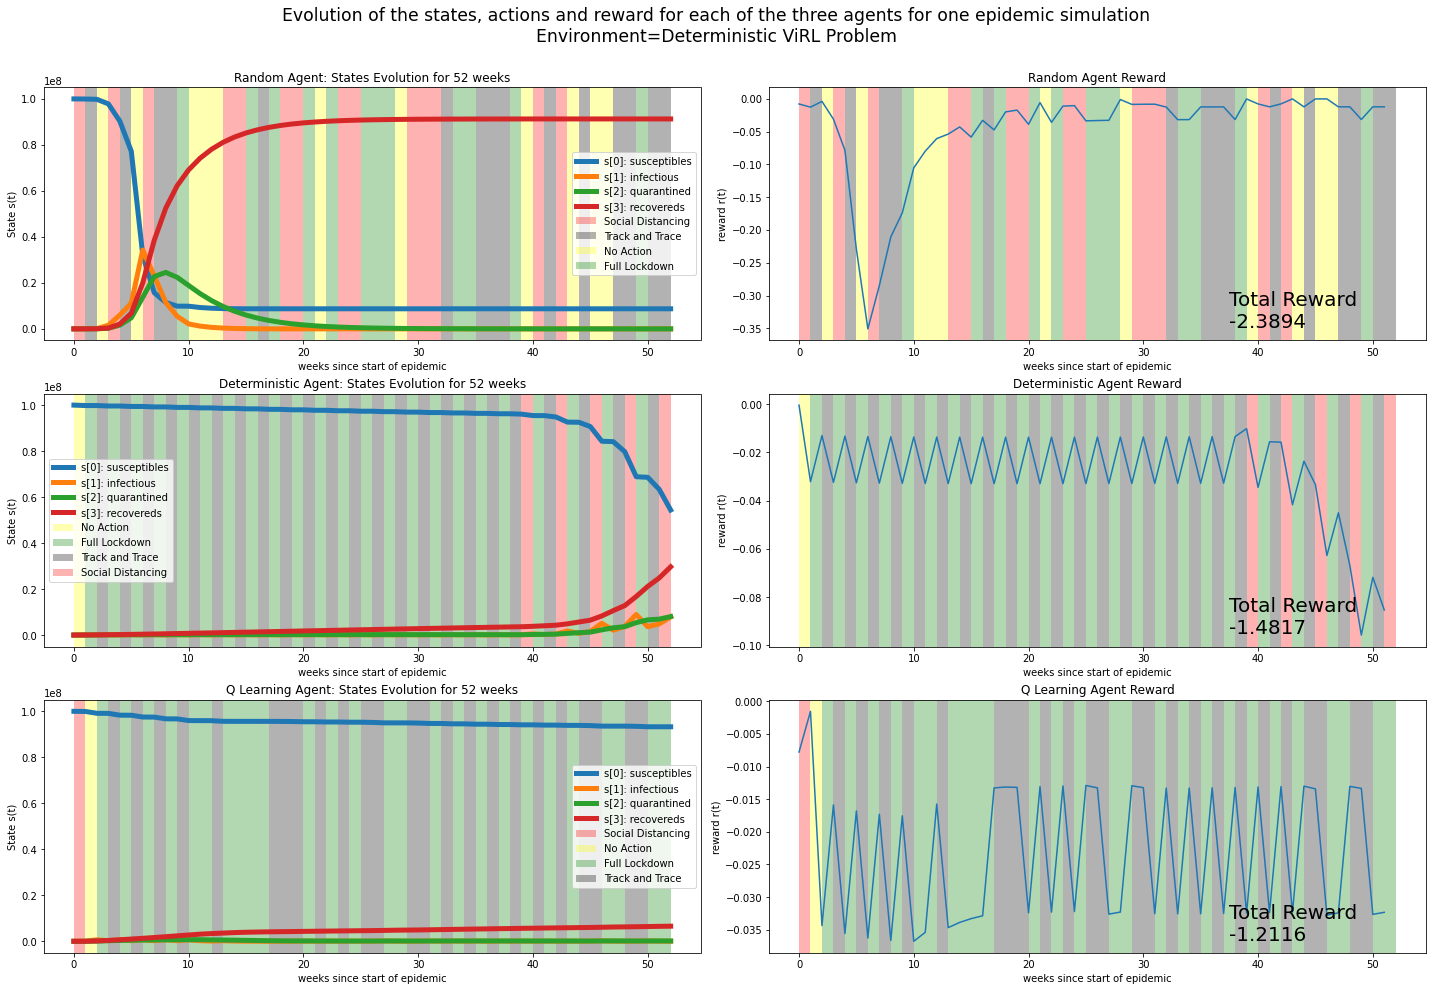

In [ ]:
all_agents_actions = [random_actions,deterministic_actions,qlearn_actions]
all_agents_states = [random_states,deterministic_states,qlearn_states]
all_agents_rewards = [random_rewards,deterministic_rewards, qlearn_rewards]
episode_stats_all_agents(all_agents_actions, all_agents_states, all_agents_rewards,"Deterministic ViRL Problem")

> As we can see from the Mandatory Visualization shown above, the trained Q-Learning Agent outperformed the other two agents with a total reward of -1.2116, whereas the Deterministic and Random agents achieved total rewards of -1.4817 and -2.3894, respectively.

> In regards to the actions performed during the simulation process, we can observe that both the Q Learning and Deterministic agents alternate between Full Lockdown and Track and Trace for nearly the entire simulation duration. However, during the last 15 weeks of the simulation, the Deterministic agent has also performed Social Distancing, resulting in a considerable reduction in the weekly rewards as well as the total reward of the agent at the end of the simulation. On the other hand, Random Agent has randomly used all four actions which cause a significant decrease in the total reward of the agent particularly in circumstances where a decrease in the susceptibles and an increase in the recovered numbers have been observed. 

> In order to maximize the simulation's overall reward, the number of susceptible people must be kept as high as feasible by the end of the simulation, while the number of infected cases must be kept as low as possible. This seems to be achieved better by the Q-Learning agent. Furthermore, as shown on the Deterministic agent simulation, the infection number increases each week when Social Distancing is used, lowering the total reward.


<a name="example_4"></a>
**Total Reward performance over 50 episodes for all the three agents with Deterministic ViRL Environment**

In [ ]:
random_200_total_rewards = []
deterministic_200_total_rewards = []
q_learning_200_total_rewards = []
for i in range(50):
  random_actions, random_rewards, random_states = random_agent(env)
  deterministic_actions, deterministic_rewards, deterministic_states = deterministic_simulator(env)
  q_learning_rewards, q_learning_actions, q_learning_states = qlearning_agent.run_agent_51_weeks(env)

  random_200_total_rewards.append(np.sum(random_rewards))
  deterministic_200_total_rewards.append(np.sum(deterministic_rewards))
  q_learning_200_total_rewards.append(np.sum(q_learning_rewards))

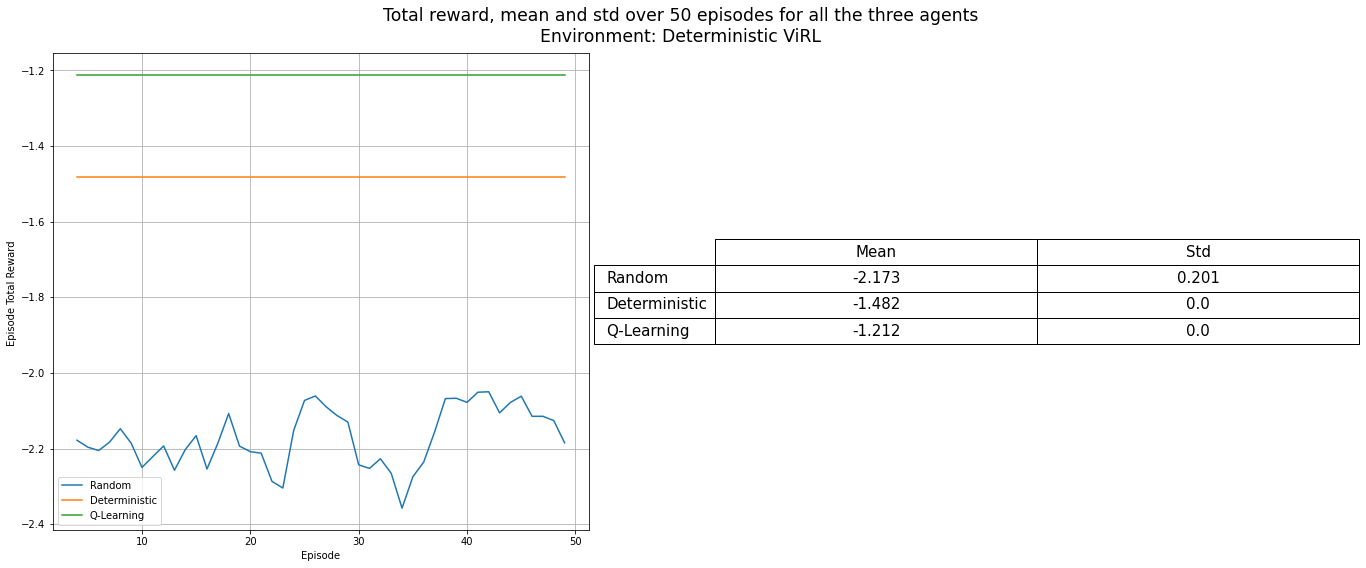

In [ ]:
agent_total_reward_vs_episode_all_agents([random_200_total_rewards, deterministic_200_total_rewards, q_learning_200_total_rewards], "Deterministic ViRL")

> The graph above depicts the total reward of each of the three agents throughout 50 episodes, as well as their mean and standard deviation. Since the agents are used in a deterministic environment with no noise, deterministic and q-learning agents maintain consistent performance across the 50 episodes, resulting in a standard deviation of 0 as expected. Furthermore, the random agent introduces a standard deviation of 0.201, which seems a reasonable value given that the agent's actions vary from week to week.

## 3.3 Determinitic ViRL problem with observational noise

>For each of the three agents, a single epidemic simulation of 52 weeks has been run and visualized using a deterministic and noisy environment


#### Environment:

In [ ]:
noisy_env = virl.Epidemic(noisy=True, problem_id = 0)

Random Agent

In [ ]:
random_actions, random_rewards, random_states = random_agent(noisy_env)
# episode_stats(random_actions, random_states, random_rewards)

Deterministic Agent

In [ ]:
deterministic_actions, deterministic_rewards, deterministic_states = deterministic_simulator(noisy_env)
# episode_stats(deterministic_actions, deterministic_states, deterministic_rewards)

Q Learning Agent

In [ ]:
qlearn_rewards, qlearn_actions, qlearn_states = qlearning_agent.run_agent_51_weeks(noisy_env)
# episode_stats(qlearn_actions, qlearn_states, qlearn_rewards)

<a name="mandatory_2"></a>

#### Mandatory Visualization 3.3

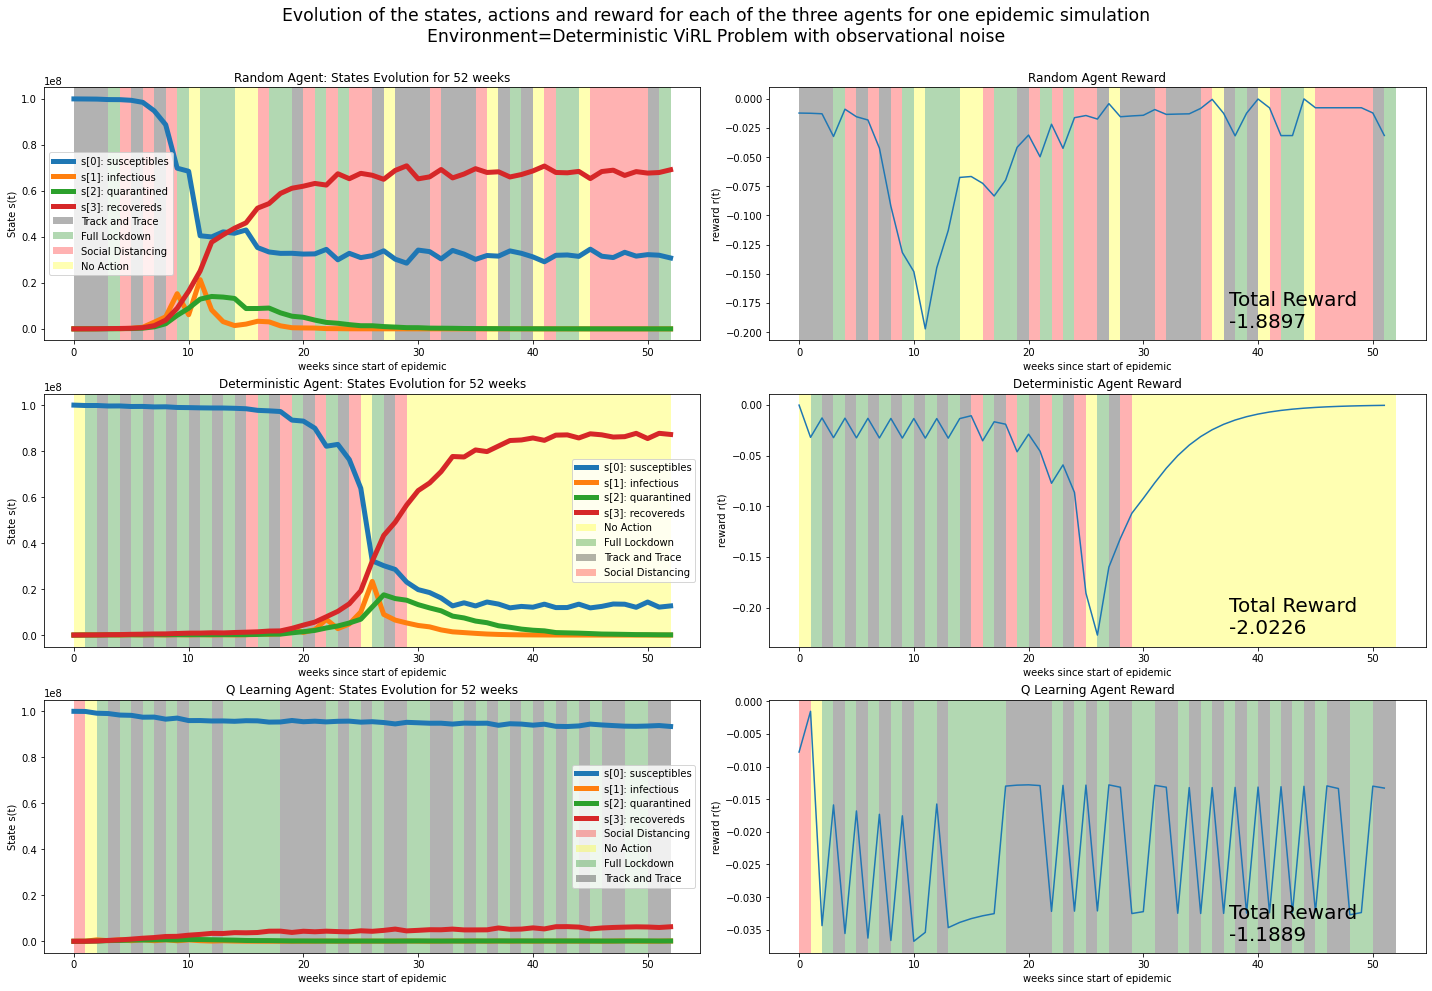

In [ ]:
all_agents_actions = [random_actions,deterministic_actions,qlearn_actions]
all_agents_states = [random_states,deterministic_states,qlearn_states]
all_agents_rewards = [random_rewards,deterministic_rewards, qlearn_rewards]
episode_stats_all_agents(all_agents_actions, all_agents_states, all_agents_rewards,"Deterministic ViRL Problem with observational noise")

>Considering the total reward at the end of the simulation, we can observe that the performance order of the agents has changed compared to the previous environment. With a total reward of -1.8897, the Random agent outperformed the Deterministic agent in this environment. Furthermore, the increased noise did not appear to have an effect on Q-Learning performance, since it has a tiny incline to -1.1889 when compared to the previous environment.<br><br>
By examining the weekly actions of each agent, we can observe a major difference in comparison to the previous case. For approximately the last 25 weeks, the deterministic agent performed no actions while Social Distancing has been performed earlier compared to the precious environment, negatively affecting the overall reward of the episode. In addition, a Social Distancing action taken in week 25 resulted in a significant reduction in the week's reward and, as a result, the total reward.  Finally, the actions taken by Q-Learning appear to be nearly identical to those in the deterministic environment.<br><br>
As illustrated in the example above, the deterministic agent appears to be the most affected by noise, with its performance dropping to -2.0226. As we can see in the following visualization, the performance of the agents varies for each simulation due to the randomization of the noise in the environment. As a result, we cannot obtain a clear view of how agents perform just on a single simulation. Therefore, in the next visualization, the comparison of agents' performance will be more conclusive since simulations are done over multiple episodes and mean and standard deviation are also taken into account. 


**Total Reward performance over 50 episodes for all the three agents with Deterministic Noisy ViRL Environment**

In [ ]:
random_200_total_rewards = []
deterministic_200_total_rewards = []
q_learning_200_total_rewards = []
for i in range(50):
  random_actions, random_rewards, random_states = random_agent(noisy_env)
  deterministic_actions, deterministic_rewards, deterministic_states = deterministic_simulator(noisy_env)
  q_learning_rewards, q_learning_actions, q_learning_states = qlearning_agent.run_agent_51_weeks(noisy_env)

  random_200_total_rewards.append(np.sum(random_rewards))
  deterministic_200_total_rewards.append(np.sum(deterministic_rewards))
  q_learning_200_total_rewards.append(np.sum(q_learning_rewards))

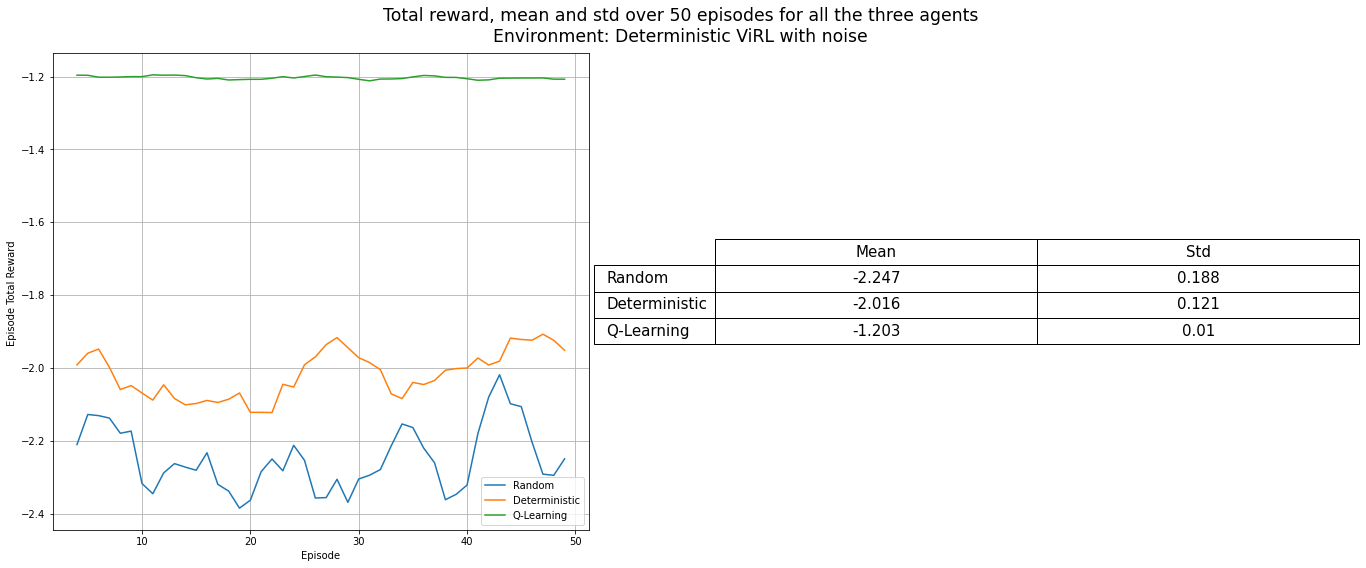

In [ ]:
agent_total_reward_vs_episode_all_agents([random_200_total_rewards, deterministic_200_total_rewards, q_learning_200_total_rewards], "Deterministic ViRL with noise")

>Based on the current visualization, the previous performance statements have been proven to be incorrect. The graph and the mean values clearly show that the Random agent is inferior to the Deterministic agent, which we couldn't identify in the previous visualization.
Moreover, a variation in the performance of all the three agents is observed due to the randomness of the noise which causes their performance to oscillate. Noise has affected the stability of the performance of the deterministic and q-learning agents with std values of 0.121 and 0.010 respectively. 


## 3.4 Stochastic ViRL problem with observational noise

>For each of the three agents, a single epidemic simulation of 52 weeks has been run and visualized using a stochastic and noisy environment

-----

#### Environment

In [ ]:
stoch_noisy_env = virl.Epidemic(stochastic = True, noisy=True, problem_id = 0)

Random Agent

In [ ]:
random_actions, random_rewards, random_states = random_agent(stoch_noisy_env)
# episode_stats(random_actions, random_states, random_rewards)

Deterministic Agent

In [ ]:
deterministic_actions, deterministic_rewards, deterministic_states = deterministic_simulator(stoch_noisy_env)
# episode_stats(deterministic_actions, deterministic_states, deterministic_rewards)

Q Learning Agent

In [ ]:
qlearn_rewards, qlearn_actions, qlearn_states = qlearning_agent.run_agent_51_weeks(stoch_noisy_env)
# episode_stats(qlearn_actions, qlearn_states, qlearn_rewards)

<a name="mandatory_3"></a>
#### Mandatory Visualization 3.4

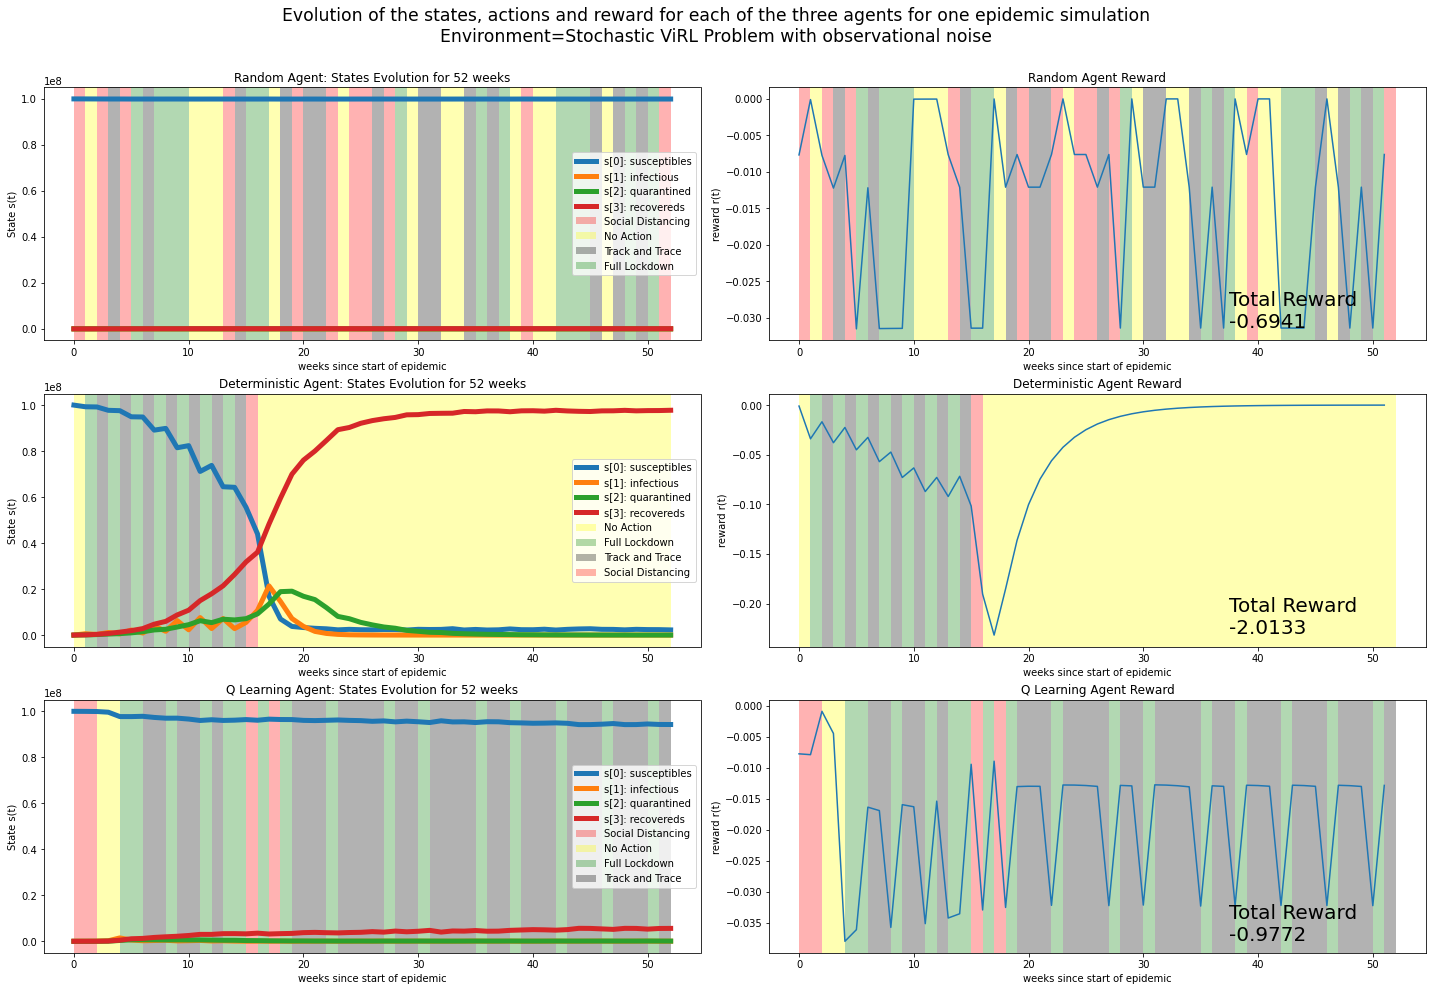

In [ ]:
all_agents_actions = [random_actions,deterministic_actions,qlearn_actions]
all_agents_states = [random_states,deterministic_states,qlearn_states]
all_agents_rewards = [random_rewards,deterministic_rewards, qlearn_rewards]
episode_stats_all_agents(all_agents_actions, all_agents_states, all_agents_rewards,"Stochastic ViRL Problem with observational noise")

>Stochastic Environment with noise has significantly affected the performance of all the three agents.<br><br>
> **Random Agent**: its performance has been surprisingly good with an unprecedented reward of -0.694. It appears that it has discovered this optimal action sequence for the current simulation. Due to the stochasticity of the environment and the randomness of the agent, running the simulation again will produce different results which might be much worse.<br><br>
>**Deterministic Agent**: When comparing the agent with the prior environments, we can see that stochasticity, unlike noise, had no effect on our agent. The taken actions and the total reward are almost the same with the deterministic noisy environment. The main reason for this is that our agent's policy is fixed and it's not affected by the nature of the information provided.<br><br>
>**Q-Learning Agent**: The Q-Learning agent, like the Random agent, showed a considerable improvement in comparison to the prior environments, with a total reward of -0.9772. Overall, the agent's weekly actions follow a similar pattern compared to the previous week, primarily moving between 3 Track and Trace steps and 1 Full Lockdown step.



**Total Reward performance over 50 episodes for all the three agents with Stochastic Noisy ViRL Environment**
<a name="Example_3"></a>

In [ ]:
random_200_total_rewards = []
deterministic_200_total_rewards = []
q_learning_200_total_rewards = []
for i in range(50):
  random_actions, random_rewards, random_states = random_agent(stoch_noisy_env)
  deterministic_actions, deterministic_rewards, deterministic_states = deterministic_simulator(stoch_noisy_env)
  q_learning_rewards, q_learning_actions, q_learning_states = qlearning_agent.run_agent_51_weeks(stoch_noisy_env)

  random_200_total_rewards.append(np.sum(random_rewards))
  deterministic_200_total_rewards.append(np.sum(deterministic_rewards))
  q_learning_200_total_rewards.append(np.sum(q_learning_rewards))

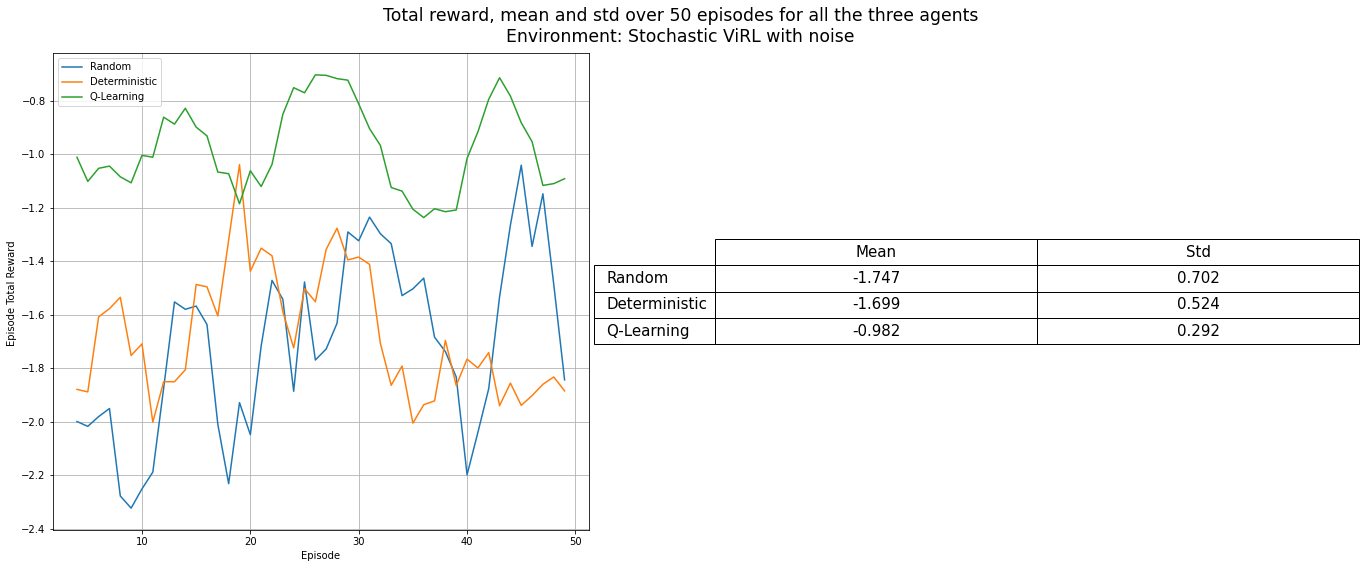

In [ ]:
agent_total_reward_vs_episode_all_agents([random_200_total_rewards, deterministic_200_total_rewards, q_learning_200_total_rewards],"Stochastic ViRL with noise")

>The magnitude of variation in performance of all the three agents has been greatly increased, as can be seen in the visualization above. All three agent plots have a higher tendency to oscillate, resulting in less consistent performance. The fundamental explanation is the environment's stochasticity, which is exacerbated by noise, resulting in high *std* values for all the three agents.<br><br>
The mean values of deterministic and random agents are -1.699 and -1.747, respectively. Despite the fact that their average performance is nearly identical, the random agent's standard deviation is the highest, making it the worst-performing agent. Q learning agent, on the other hand, appears to perform the best, with a mean value of -0.982 and the smallest standard deviation of 0.292.<br><br>
Overall, the mean performances of all three agents seem to have a significant increase compared to the previous deterministic environments. From that, we can confirm the robustness of the trained Q-Learning agent.


## 3.5 Improving generalization performance

>Due to the limitations of the already developed Double Q-Learning Agent, a prioritized experience replay (PER) can be implemented for better generalization and further improvement of the model's robustness, particularly in a stochastic environment. PER will act as a replacement for the ReplayMemory class.
>
>A key advantage of PER over ReplayMemory is that the important samples are taken more frequently for training. This is accomplished by selecting samples with the greatest temporal difference (TD) error, which are then fed into the NN and minimized in the Bellman equation [3]. Absolute TD value δ, is added as a component for each sample. A proportional variant is then calculated based on δ and the probability of sampling transition is defined as:<br>
$$P(i)=\frac{pᵅᵢ}{Σₖpₖᵅ} $$
>
>Due to time constraints, PER has not been successfully implemented nor included in the report. However, I am confident that taking into account previous experiences in cases where NN successfully predicted the Q value, would improve model accuracy and as a result, the model's stability and robustness. 





# 4. Real-world reflection

***Could the optimal policies you developed in this work be used to inform decision making by politicians?***

----

>Incorporating decision-making via the Q-Learning policy will result in a slew of concerns and challenges. To begin with, the simulated COVID-19 environment cannot accurately reflect a country's actual environment. As a result, in most circumstances, the actions taken won't be the optimal ones. Furthermore, even if the economic opportunity cost is considered within the reward of each action, a country's financial situation may not be able to handle that economic 'reward' which can then lead to other economic problems apart from the virus spread. Moreover, due to wrong actions taken, the transmission of the virus can accelerate exponentially. This has the potential to increase the number of deaths caused by COVID. Finally, another concern that has arisen as a result of this is the legal liability of those who committed that act. Who is going to be held accountable for all of the troubles that have arisen as a result of that wrongdoing, the AI engineers or politicians?<br><br>
>As we can see from one of the mandatory visualizations, the actions performed vary from week to week, with some cases alternating between two actions on a weekly basis. In a real scenario, performing Full Lockdown every two weeks would be more than unethical. Therefore, there are many additional aspects to consider aside from those employed in the simulated environment, such as psychological, environmental and economic factors. <br><br>
>Taking everything into consideration, I strongly believe that automated decision-making should be avoided in such vital situations. However, the optimal policies of the AI system can serve as recommendations to pandemic experts and politicians in charge of enforcing restrictions. Having different points of view from a different perspective is always a good idea.


# 5. Discussion

>When it comes to dealing with agents and neural networks, I have learned and acquired a lot throughout this coursework. Despite the fact that the coursework seemed to be impossible to finish at the beginning, it appears that I have just completed it in a satisfactory state after endless working hours. In addition, even though a significant part of the Q learning agent's code was provided by the labs, adapting it in the ViRL environment and making the agent learn were both challenging and pleasant elements of the assessed exercise.<br><br>
The use of the Q-Learning agent in a stochastic environment appears to have a few limitations, which I attempted to address in section 3.5. Even though the model appeared to be sufficiently generalized in a deterministic environment, the Q-Learning agent's performance fluctuates significantly during stochasticity, resulting in a large standard deviation value.


---
---

# ===EOF===

> This is a flag to tell the word counter to stop counting, anything in and below this cell will not be counted towards your report word count.
>
> Please do change this cell, any word below EOF does not count toward your report word count. Also please do not try to be snicky about the word counter; embrace the constraints we give you rather than fight them.

# References

- [1]	Experience Replay. https://paperswithcode.com/method/experience-replay.
 
- [2]	Mike Wang. 2020. Deep Q-Learning Tutorial: minDQN. https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc (2020).

- [3]	Daniel Seita. 2019. Understanding Prioritized Experience Replay. https://danieltakeshi.github.io/about.html (2019).

## Generate and export your files

> Well done! Now run the cell below and it will generate all the files you need for your submission

In [ ]:
# Exporting your submission files

###########################################
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Please do not change this code cell in any way
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
###########################################

# checking you did read the above cell and added your information
# again please be smart and add your information above rather than modifying the code below
STUDENT_CHANGED_DEFAULT_VALUES = True

# checking you entered a student number
if YOUR_STUDENT_NUMBER == "REPLACE_WITH_YOUR_STUDENT_NUMBER":
  STUDENT_CHANGED_DEFAULT_VALUES = False
  print("###########################################")
  print("")
  print("Please add your student number in the YOUR_STUDENT_NUMBER variable in the code cell above!")
  print("")
  print("###########################################")

# checking you entered a URL that works
if SHARING_URL_FOR_THIS_COLAB == "REPLACE_WITH_YOUR_SHARING_URL_FOR_THIS_COLAB" :
  STUDENT_CHANGED_DEFAULT_VALUES = False
  print("###########################################")
  print("")
  print("Please add your Colab sharing URL number in the `SHARING_URL_FOR_THIS_COLAB` variable in the code cell above!")
  print("")
  print("###########################################")

if not STUDENT_CHANGED_DEFAULT_VALUES:
  raise ValueError('You have not added you student number and/or shared the sharing URL for your Colab notebook. \n Please read the above cells carefully.')


# define some folder and file names
import os 
report_foldername = "COMPSCI_4004_Coursework_{}".format(YOUR_STUDENT_NUMBER)
report_folderpath = os.path.join("/content", report_foldername)
ipynb_filename = os.path.join(report_folderpath, "report_{}.ipynb".format(YOUR_STUDENT_NUMBER))
html_redirect_filename = os.path.join(report_folderpath, "colab_link_{}.html".format(YOUR_STUDENT_NUMBER))
report_zip_filename = os.path.join(report_folderpath, "{}.zip".format(report_foldername))

# create folder if it does not exist
if not os.path.exists(report_folderpath):
  print("Creating {} folder...".format(report_folderpath))
  os.mkdir(report_folderpath)

# Obtain the notebook JSON as a string
print("Saving notebook as {}...".format(ipynb_filename))

from google.colab import _message
notebook_json = _message.blocking_request('get_ipynb', request='', timeout_sec=500)

# save ipynb part into a file locally
import json
with open(ipynb_filename, 'w') as f:
    f.write(json.dumps(notebook_json["ipynb"]))
    
# export to html
print("Exporting notebook as html file...")
os.system("jupyter nbconvert --to html {}".format(ipynb_filename))

#export to pdf
print("Exporting notebook as pdf file...")
## make sure xetex is installed
print("Installing required librarie, this might take a while, be patient...")
!apt-get -qq install texlive-xetex texlive-fonts-recommended texlive-generic-recommended > /dev/null
## export to pdf
os.system("jupyter nbconvert --to pdf {}".format(ipynb_filename))

# paste the url for this colab in a html file redirecting to it
print("Creating html redirecting file to your Colab...")

html_redirect_content = """
<!DOCTYPE HTML>
<html lang="en-US">
    <head>
        <meta charset="UTF-8">
        <meta http-equiv="refresh" content="0; url={colab_link}">
        <script type="text/javascript">
            window.location.href = "{colab_link}"
        </script>
        <title>Page Redirection</title>
    </head>
    <body>
        <!-- Note: don't tell people to `click` the link, just tell them that it is a link. -->
        If you are not redirected automatically, follow <a href='{colab_link}'>{colab_link}</a>.
    </body>
</html>
""".format(colab_link=SHARING_URL_FOR_THIS_COLAB)

with open(html_redirect_filename, 'w') as f:
    f.write(html_redirect_content)

# # zip the folder with all results
print("Making a zip file of the all thing...")
os.system("cd {}; zip -r {} *".format(report_folderpath, report_zip_filename))

# download the zip folder for submission
print("Downloading the zip file to your computer...")

from google.colab import files
files.download(report_zip_filename)

#
print("")
print("All done! Check and submit the downloaded zip file")

Saving notebook as /content/COMPSCI_4004_Coursework_2380007v/report_2380007v.ipynb...
Exporting notebook as html file...
Exporting notebook as pdf file...
Installing required librarie, this might take a while, be patient...
Extracting templates from packages: 100%
Creating html redirecting file to your Colab...
Making a zip file of the all thing...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All done! Check and submit the downloaded zip file
